#### Задание 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов. 

In [270]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [271]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

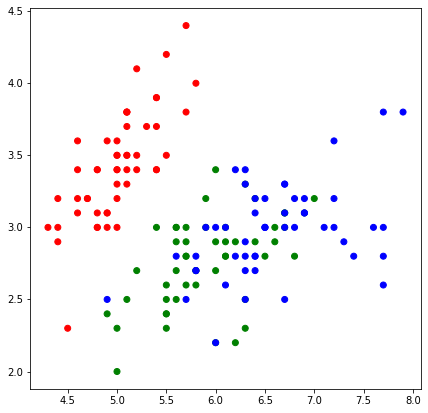

In [273]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [274]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [275]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Определим вес соседа на основе рассчитанного расстояние от объекта тестовой выборки до этого соседа
            # Протестируем 2 варианта нахождения весов
            
            #w = 1/(i+1) - в зависимости от порядкового номера 
            
            # в зависимости от расстояния
            q = 0.5
            w = q**distance
            
            # Записываем в список значения: 
            # произведение дистанции на вес и 
            # ответа на объекте обучающей выборки
            
            test_distances.append((w*distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
       
    return answers

In [276]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [277]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.733


#### Задание 2*. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [278]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, random_state=1)

In [279]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            # расстояний столько, сколько кластеров
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            #минимальное расстояние считаем за кластер
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters


In [280]:
# k - количество кластеров
def mean_sq_cluster_cohesion(k, centroids, clusters):
    p_total = 0

    for i in range(k):
        for el in clusters[i]:
            p = np.linalg.norm((el - centroids[i]))
            p_total+=p
            
    mean_sq_cluster_cohesion = 1/k * p_total**2
    
    return mean_sq_cluster_cohesion
    #print(p_total)
    

In [281]:
k = 3
centroids, clusters = kmeans(X, k, max_iterations, min_distance)


In [282]:
# определим максимальное количество итераций
max_iterations = 1

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3
centroids, clusters = kmeans(X, k, max_iterations, min_distance)
mean_sq_cluster_cohesion(k, centroids, clusters)

23825.135834480683

In [283]:
number_of_clusters = [i for i in range(1,11)]
def elbow_method(clusters):
    metrics = []
    for i in number_of_clusters:
        centroids, clusters = kmeans(X, i, max_iterations, min_distance)
        metric = mean_sq_cluster_cohesion(i, centroids, clusters)
        metrics.append(metric)
    return metrics

In [284]:
elbow_method(number_of_clusters)

[704871.2041554427,
 39176.595902028355,
 23825.135834480683,
 16033.225752154234,
 6821.800745964522,
 3430.031972592825,
 2802.5386657121394,
 2426.929353819233,
 1227.6044586960898,
 727.0254404058105]

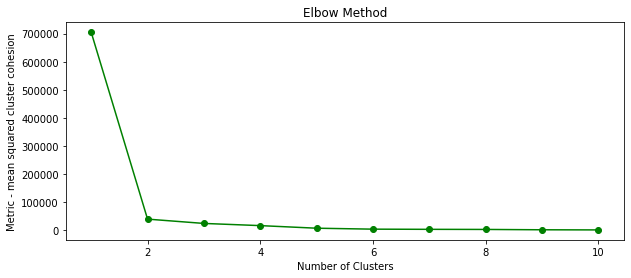

In [285]:
plt.figure(figsize = (10,4))
plt.plot(number_of_clusters, elbow_method(number_of_clusters), 'go-')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric - mean squared cluster cohesion')
plt.title('Elbow Method')

plt.show()

Заметен "загиб локтя" при количестве кластеров = 2